In [213]:
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, brier_score_loss, f1_score
from IPython.display import Image


In [4]:
from utils import parse_url, restore_data, categories
from predict import evaluate, get_true_label, extract_predicted_cat, results_as_df

In [5]:
docs = pd.read_csv('./data/data_redacted.tsv', sep='\t')

# EDA

In [6]:
# number of articles in the dataset
len(docs)

8646

In [168]:
docs.head()

,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle


## Label Distribution

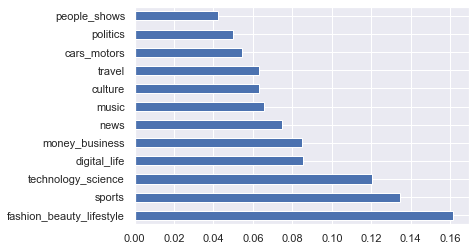

In [169]:
sns.set_theme()
docs.category.value_counts(normalize=True).plot(kind='barh')
plt.show()

In [9]:
webpages = pd.Series([parse_url(url) for url in docs["url"]])
# most frequent news websites in the dataset
webpages.value_counts(normalize=True).head(8)

www.theguardian.com      0.104441
www.telegraph.co.uk      0.050891
www.independent.co.uk    0.049850
www.bbc.com              0.027759
www.dailymail.co.uk      0.024057
www.mirror.co.uk         0.022091
www.express.co.uk        0.019894
phys.org                 0.013879
dtype: float64

It seems that the websites from which the articles are taken, are general news websites (as opposed to websites dedicated to a single topic, i.e. sports). That suggests that the source of the article may not be a very good indicator for its topic

# Modeling Details

In this work, I used SpaCy V3.2 TextCatagorizer for the following reasons:
* SpaCy offers "off the shelf" solution which is easy to model, maintain and read. It is also usually fast and scalable and hence suitable for production (in real production setting, there is no use for customized model if it can't beat an of the shelf solution that serves as a baseline.
* I used earlier versions of SpaCy and I wanted to try the V3 which introduces (among other things) a cleaner (less boilerplates) way to train models

SpaCy's TextCategorizer uses a very simple architecture:
* The document is tokenized, and ngrams are being pulled
* for each ngram a (pre trained) vector representation is fetched from SpaCy's
* vectors are passed to a sinfle linear layer
* A softmax layer is add on top

The entire hyper-parameters set can be found on config.cfg file

I trained a (very) basic model, with just a single epoch and achieved an accuracy of about 71%, which is better than random...
It seems that this architecture can do much better with this data, if trained properly.

The analysis I'm about to present is done using this model I described above. It was trained on 85% of the the data (train and validation) from which 10% (and overall 8.5%) used as validation set.
The performance is evaluated on 15% of the data which serves as a test set and was not seen by the model at any stage

# Analyze Test Set Predictions

## Extract Predictions

In [10]:
doc_classfier = spacy.load("./output/model-best")
test = restore_data("./data/test.spacy", doc_classfier)
test_pred = restore_data("./data/test_with_pred.spacy", doc_classfier)

In [11]:
predictions = [extract_predicted_cat(doc) for doc in test_pred]
labels = [get_true_label(doc) for doc in test]

In [71]:
results = results_as_df(labels=labels, predictions=predictions).\
assign(is_correct=lambda row: row.label==row.predicted)

In [171]:
acc, conf = evaluate(labels=labels, predictions=predictions, categories=categories)

overall accuracy: 0.71


## Confusion Matrix

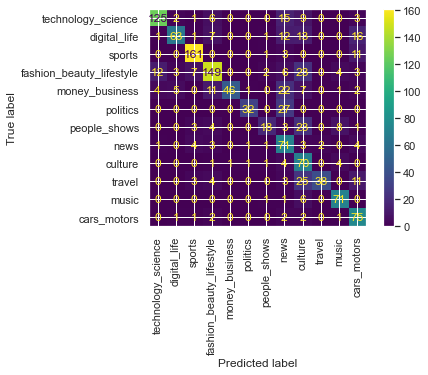

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=categories)
disp.plot(xticks_rotation='vertical')
plt.show()

The same chart, as an image, to make it easier to look at:

![title](charts/conf_mat.png)

Few comments regarding the confusion matrix:
* Documents about "politics" are often misclassified as "news". These are indeed similar topics but it is interesting to note that "news" are almost never misclassified
* "Travel" are often misclassified as "culture" and, to a lesser extent, as "cars motors". This makes sense as "culture" and "travel" are indeed overlapping while "cars motors" documents may use words like "airplane" or "train" which are also mentioned on "travel" documents
* "People shows" is often misclassified as "culture" - makes sense


## Misclassification Errors

To focus on misclassification, let's extract, for each the category, the category it is most often misclassified for:

In [51]:
misclass = conf.copy()
np.fill_diagonal(misclass, 0)
misclass_df = pd.DataFrame(misclass, columns=categories).assign(category=categories).set_index("category")

In [56]:
misclass_df.head()

,technology_science,digital_life,sports,fashion_beauty_lifestyle,money_business,politics,people_shows,news,culture,travel,music,cars_motors
category,,,,,,,,,,,,
technology_science,0,2,1,6,0,0,0,15,9,0,0,3
digital_life,1,0,1,7,0,0,1,12,13,0,0,16
sports,0,0,0,0,0,0,1,3,0,0,0,11
fashion_beauty_lifestyle,12,3,7,0,0,0,2,6,23,0,4,3
money_business,4,5,0,11,0,1,0,22,7,0,1,2


The most common misclassification error per (true) category:

In [64]:
misclass_df.transpose().\
apply(lambda s: s.nlargest(1)).apply(lambda s: s[~(s.isna())].index).transpose().\
rename(columns={0: "most_common_misclassification"})

,most_common_misclassification
category,
technology_science,news
digital_life,cars_motors
sports,cars_motors
fashion_beauty_lifestyle,culture
money_business,news
politics,news
people_shows,culture
news,sports
culture,news


## Score Distribution, Accuracy and Coverage

In [68]:
results.head()

,label,predicted,score,correct
0,people_shows,culture,0.563158,False
1,sports,sports,0.999639,True
2,money_business,money_business,0.718311,True
3,fashion_beauty_lifestyle,fashion_beauty_lifestyle,0.995138,True
4,technology_science,technology_science,0.895554,True


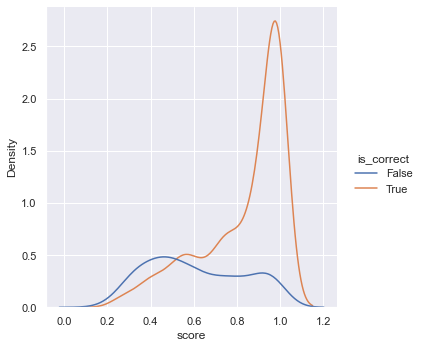

In [72]:
sns.displot(results, x="score", hue="is_correct", kind="kde")
plt.show()

The above KDE plots show that when we classify correctly, the probability we give to the predicted class (that is, the highest probability among all classes) is usually high (close to 1), where as when we make a classification error, it is often the case that the model is "not sure" regarding the correct class and therefore assigns relatively low probabilities.

That is a good attribute of a classification model, sense it allows us to adopt some threshold probability, say 0.8, and classify only documents with for which the most probable category is assigned a higher score. 
That might be useful if we have "human in the loop" and cam assign "hard examples" to be manually tagged.  

That will increase accuracy with a price of lower coverage. We will now see that:

In [100]:
def calc_acc_cov(results, cutoff):
    predictions = np.where(results.score >= cutoff, results.predicted, None)
    is_correct = [pred == cat for pred, cat in zip(predictions, results.label) if pred]
    non_class = [pred is None for pred in predictions]
    acc = np.mean(is_correct)
    cov = 1 - np.mean(non_class)
    return {"accuracy": acc, "coverage": cov}
    
    

In [101]:
calc_acc_cov(results, cutoff=0.7)

{'accuracy': 0.8380614657210402, 'coverage': 0.6522744795682344}

In [141]:
def get_acc_cov_characteristic(results, cutoffs):
    acc_cov = []
    for cutoff in cutoffs:
        x = calc_acc_cov(results, cutoff)
        x["cutoff"] = cutoff
        acc_cov.append(x)
    return pd.DataFrame(acc_cov).set_index("cutoff")

In [142]:
acc_cov_char = get_acc_cov_characteristic(results, cutoffs=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [143]:
acc_cov_char

,accuracy,coverage
cutoff,,
0.4,0.743460,0.913647
0.5,0.780694,0.822668
0.6,0.814696,0.723978
0.7,0.838061,0.652274
0.8,0.864979,0.548188
0.9,0.892035,0.435621


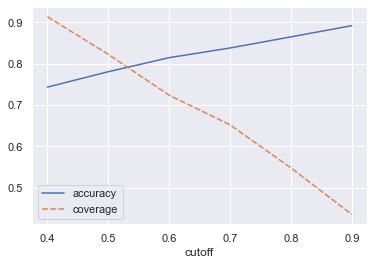

In [144]:
sns.lineplot(data=acc_cov_char)
plt.show()

## Other Metrics for Multi-class Classification 

Since I didn't consider other models or configurations of the same model, no model selection was done.
However, I had to improve this model, I would hyper-parameter tune it (at least) and then conduct model selection.
The following function allows to easily extract some other metrics (other than just global accuracy) 

In [200]:
def calc_metrics(labels, predictions):
    y_prob=[pred.score for pred in predictions]
    y_true_prob=[int(label == pred.cat) for label, pred in zip(labels, predictions)]
    y_pred=[pred.cat for pred in predictions]
    
    brier = brier_score_loss(y_prob=y_prob, y_true=y_true_prob)
    f1_macro = f1_score(y_true=labels, y_pred=y_pred, average='macro')
    f1_micro = f1_score(y_true=labels, y_pred=y_pred, average='micro')
    f1_weighted = f1_score(y_true=labels, y_pred=y_pred, average='weighted')
    
    return brier, f1_macro, f1_micro, f1_weighted

In [212]:
brier, f1_macro, f1_micro, f1_weighted = calc_metrics(labels, predictions)
print(f"Micro F1 score {f1_micro:.2f}\n\
Macro F1 score {f1_macro:.2f}\n\
Weighted F1 score {f1_weighted:.2f}\n\
Brier score {brier:.2f}")

Micro F1 score 0.71
Macro F1 score 0.68
Weighted F1 score 0.71
Brier score 0.17


# Error Analysis

It might be interesting to look at some misclassified examples, I will do so (very) briefly

In [147]:
results_with_text = results.assign(text = test)

In [153]:
news_politics = results_with_text.query("predicted == 'news' and label == 'politics'")

In [164]:
news_politics.head(6)

,label,predicted,score,is_correct,text
6,politics,news,0.803727,False,"(Three, quarters, of, children""s, services, we..."
48,politics,news,0.761447,False,"(Unchecked, pollution, and, bad, food, ‘, kill..."
73,politics,news,0.488296,False,"(Which, would, you, rather, ,, President, Trum..."
177,politics,news,0.510563,False,"(Barack, Obama, says, world, needs, a, united,..."
186,politics,news,0.587731,False,"(Mexico, gov""t, offers, to, negotiate, educati..."
193,politics,news,0.532924,False,"(Trump, still, leads, NH, ,, but, Christie, ri..."


In [166]:
doc = news_politics.text.iloc[1]
doc.text[0:700]

'Unchecked pollution and bad food ‘killing thousands in UK’ Thousands of people are dying each year because of the government’s failure to tackle food poisoning, health and safety breaches and pollution, a thinktank is warning. A new report from the Centre for Crime and Justice Studies (CCJS) claims that lax regulation and weak enforcement are failing to hold businesses in check and are tantamount to state-facilitated “social murder”. The report, by Professor Steve Tombs, head of social policy and criminology at the Open University, claims that some 29,000 deaths in the UK are attributable to airborne pollution alone. A further 50,000 people die as a result of injuries or health problems orig'

To be honest, I'm not sure how would I tag this article myself.., It isn't clear cut. I think at least some people would say it is more "news" than "politics"

In [161]:
doc = news_politics.text.iloc[5]
doc.text[0:500]

'Trump still leads NH, but Christie rising Another poll shows Donald Trump preserving his lead in New Hampshire despite controversy surrounding his call for a ban on Muslim entry to the U.S., while challenger Chris Christie"s has ridden a wave of recent momentum to second place and support for Ben Carson continues to slide. According to the new poll from WBUR in Boston , Trump remains in first place with the support of 27% of likely Republican primary voters. But New Jersey Governor Christie has '

This indeed seems very politic (and indeed the score for news is relatively low)